In [1]:
using LinearAlgebra, Plots, PGFPlotsX, LaTeXStrings, ProgressBars
pgfplotsx()

Plots.PGFPlotsXBackend()

In [2]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Barycenter_algorithms.ipynb")

barycenter_functional (generic function with 1 method)

In [3]:
function GM(X,Y,t)
    tmp = X^(.5)
    return Symmetric(tmp*(tmp\Y/tmp)^t*tmp)
end

GM (generic function with 1 method)

### For more details see Algorithm 3 of "Riemannian optimization via Frank-Wolfe methods" by Weber & Sra

In [4]:
function RFW(covs, nIter)
    d = size(covs)[1]
    n = size(covs)[3]
    β = minimum([eigvals(Symmetric(covs[:,:,i]), 1:1) for i in 1:n])
    A = zeros(d,d)
    for i in 1:n
        A .+= covs[:,:,i]
    end
    A ./= n
    
    Xs = zeros(d,d,nIter)
    Xs[:,:,1] = Symmetric(covs[:,:,1])
    for k in 1:nIter-1
        Xₖ = @view Xs[:,:,k]
        ∇ = zeros(d,d)
        for i in 1:n
            Aᵢ = @view covs[:,:,i]
            ∇ .+= I(d) .- GM(Aᵢ, Xₖ^(-1), .5)
        end
        ∇ ./= n
        ∇ .= Symmetric(∇)
        X = Xₖ^(-.5)
        tmp = Xₖ^(.5)
        S = tmp*∇*tmp
        L = β.*I(d)
        
        U = A
        e = eigen(S)
        Q = e.vectors
        D₊ = max.(0,diagm(-sign.(e.values)))
        Û = Symmetric(Q'*X*U*X*Q)
        L̂ = Symmetric(Q'*X*L*X*Q)
        P = cholesky(Û-L̂).U
        Z = X\Q*(P'*D₊*P+L̂)*Q'/X
        Xs[:,:,k+1] .= GM(Xₖ, Z, 2.0/(k+1))
    end
    return Xs
end

RFW (generic function with 1 method)

In [5]:
α = .03
β = 30
κ = β/α

d=50
n=50
nIter = 200
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

gen1(covs, sqrt_covs, α, β)

In [6]:
X_RFW = RFW(covs, nIter);

In [7]:
gd_obj = zeros(nIter)
GD_dist = zeros(nIter)
sqrt_best = GD!(nIter, covs, sqrt_covs, gd_obj, zeros(nIter), 1, zeros(nIter), covs[:,:,1]);
sqrt_best = GD!(nIter, covs, sqrt_covs, gd_obj, zeros(nIter), 1, GD_dist, sqrt_best);

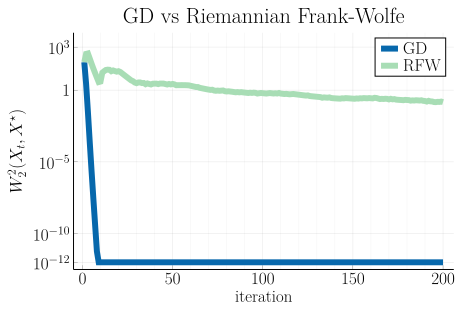

In [8]:
dists = zeros(nIter, 2)
dists[:,1] = GD_dist
dists[:,2] = [bures(sqrt_best, X_RFW[:,:,i]) for i in 1:nIter]
plot(log10.(max.(1e-12, dists)), color_palette=palette(:GnBu_6), 
     title = string(L"\textrm{GD vs Riemannian Frank-Wolfe}"), 
    ylabel = L"W_2^2(X_t,X^\star)",
    xlabel = L"\textrm{iteration}",
    minorgrid=true,
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22,
    labels=["GD" "RFW"],
    linecolors = [6 3],
    legend=:topright,
        linewidth = 6)
yticks!([3, 0,-5,-10, -12], ["10^3", "1", "10^{-5}", "10^{-10}", "10^{-12}"])
ylims!(-12.5,4)

In [ ]:
savefig(plt, "./figures/RFW")